In [2]:
!git clone https://github.com/laxmimerit/twitter-suicidal-intention-dataset.git -q
!pip install neattext -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 2.1 MB/s eta 0:00:00


### Load Dataset and Preprocess

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


In [4]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from neattext.pipeline import TextPipeline
import neattext.functions as nfx
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


df = pd.read_csv("/content/twitter-suicidal-intention-dataset/twitter-suicidal_data.csv")


def clean_the_text(text):
    p = TextPipeline(steps=[nfx.remove_special_characters, nfx.remove_punctuations,
                                nfx.remove_puncts, nfx.remove_stopwords, nfx.fix_contractions])
    return p.fit(text)


df['processed_text'] = df['tweet'].apply(clean_the_text)



train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


tokenizer=Tokenizer()
tokenizer.fit_on_texts(df.processed_text)

train_text_seq=tokenizer.texts_to_sequences(train_df.processed_text)
train_text_pad=pad_sequences(train_text_seq,maxlen=50)


test_text_seq=tokenizer.texts_to_sequences(test_df.processed_text)
test_text_pad=pad_sequences(test_text_seq,maxlen=50)


X_train_tensor = torch.tensor(train_text_pad, dtype=torch.long)
X_test_tensor = torch.tensor(test_text_pad, dtype=torch.long)
y_train_tensor = torch.tensor(train_df.intention.values, dtype=torch.long)
y_test_tensor = torch.tensor(test_df.intention.values, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)




# Word embedding using word2vec

In [5]:
import gensim.downloader as api
import torch
import torch.nn as nn

word2vec_model = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [6]:
embedding_dimension = 300

embedding_matrix = torch.zeros(len(tokenizer.word_index) + 1, embedding_dimension)
for word, index in tokenizer.word_index.items():
    if word in word2vec_model:
        embedding_matrix[index] = torch.tensor(word2vec_model[word], dtype=torch.float32)

embedding_layer = nn.Embedding.from_pretrained(embedding_matrix)


In [7]:
del word2vec_model

In [8]:
num_classes = 2

# CNN + 2LSTM

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

class CNN_LSTM(nn.Module):
    def __init__(self, embedding_matrix, num_classes, lstm_hidden_size=128):
        super(CNN_LSTM, self).__init__()

        self.embedding_layer = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)
        self.conv1d_layer = nn.Conv1d(in_channels=embedding_matrix.size(1), out_channels=64, kernel_size=3)
        self.relu_layer = nn.ReLU()
        self.maxpool_layer = nn.MaxPool1d(kernel_size=2)
        self.dropout_layer = nn.Dropout(p=0.5)
        self.lstm_layer1 = nn.LSTM(64, lstm_hidden_size, bidirectional=True, batch_first=True)
        self.lstm_layer2 = nn.LSTM(lstm_hidden_size * 2, lstm_hidden_size, bidirectional=True, batch_first=True)
        self.fc_layer = nn.Linear(lstm_hidden_size * 2 * 2, num_classes)

    def forward(self, input_sequence):
        embedded = self.embedding_layer(input_sequence)
        embedded = embedded.permute(0, 2, 1)
        conv_output = self.conv1d_layer(embedded)
        relu_output = self.relu_layer(conv_output)
        pooled_output = self.maxpool_layer(relu_output)
        dropped_output = self.dropout_layer(pooled_output)
        lstm_output1, _ = self.lstm_layer1(dropped_output)
        lstm_output2, _ = self.lstm_layer2(lstm_output1)
        lstm_output = torch.cat((lstm_output1[:, -1, :], lstm_output2[:, -1, :]), dim=1)
        output = self.fc_layer(lstm_output)

        return output


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim

class TwoLayerLSTM(nn.Module):
    def __init__(self, embedding_matrix, num_classes, lstm_hidden_size=128):
        super(TwoLayerLSTM, self).__init__()

        self.embedding_layer = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)
        self.lstm_layer1 = nn.LSTM(embedding_matrix.size(1), lstm_hidden_size, bidirectional=True, batch_first=True)
        self.lstm_layer2 = nn.LSTM(lstm_hidden_size * 2, lstm_hidden_size, bidirectional=True, batch_first=True)
        self.fc_layer = nn.Linear(lstm_hidden_size * 2 * 2, num_classes)

    def forward(self, input_sequence):
        embedded = self.embedding_layer(input_sequence)
        lstm_output1, _ = self.lstm_layer1(embedded)
        lstm_output2, _ = self.lstm_layer2(lstm_output1)
        lstm_output = torch.cat((lstm_output1[:, -1, :], lstm_output2[:, -1, :]), dim=1)
        output = self.fc_layer(lstm_output)

        return output


In [11]:
import torch.nn as nn

class OneLayerLSTM(nn.Module):
    def __init__(self, embedding_matrix, num_classes, lstm_hidden_size=128):
        super(OneLayerLSTM, self).__init__()

        self.embedding_layer = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)
        self.lstm_layer = nn.LSTM(embedding_matrix.size(1), lstm_hidden_size, bidirectional=True, batch_first=True)
        self.fc_layer = nn.Linear(lstm_hidden_size * 2, num_classes)

    def forward(self, input_sequence):
        embedded = self.embedding_layer(input_sequence)

        # LSTM layer
        lstm_output, _ = self.lstm_layer(embedded)

        # Concatenate the outputs of the LSTM layer
        lstm_output = torch.cat((lstm_output[:, -1, :lstm_output.size(2)//2], lstm_output[:, 0, lstm_output.size(2)//2:]), dim=1)

        # Fully Connected Layer (Output Layer)
        output = self.fc_layer(lstm_output)

        return output

100%|██████████| 114/114 [00:58<00:00,  1.96it/s]


Epoch 1/20, Average Loss: 0.3822645509713574
F1 Score: 0.8586, Recall: 0.8186, Precision: 0.9027


100%|██████████| 114/114 [00:54<00:00,  2.08it/s]


Epoch 2/20, Average Loss: 0.29207255580184754
F1 Score: 0.8682, Recall: 0.8472, Precision: 0.8903


100%|██████████| 114/114 [00:54<00:00,  2.08it/s]


Epoch 3/20, Average Loss: 0.25267513298936056
F1 Score: 0.8797, Recall: 0.8447, Precision: 0.9177


100%|██████████| 114/114 [00:44<00:00,  2.59it/s]


Epoch 4/20, Average Loss: 0.23821822599622242
F1 Score: 0.8769, Recall: 0.8360, Precision: 0.9219


100%|██████████| 114/114 [00:36<00:00,  3.14it/s]


Epoch 5/20, Average Loss: 0.21759840336285138
F1 Score: 0.8847, Recall: 0.8435, Precision: 0.9301


100%|██████████| 114/114 [00:39<00:00,  2.92it/s]


Epoch 6/20, Average Loss: 0.20642698288225292
F1 Score: 0.8931, Recall: 0.8720, Precision: 0.9153


100%|██████████| 114/114 [00:37<00:00,  3.08it/s]


Epoch 7/20, Average Loss: 0.18576363768232496
F1 Score: 0.8855, Recall: 0.9031, Precision: 0.8686


100%|██████████| 114/114 [00:37<00:00,  3.05it/s]


Epoch 8/20, Average Loss: 0.17471777762106636
F1 Score: 0.8973, Recall: 0.8795, Precision: 0.9159


100%|██████████| 114/114 [00:37<00:00,  3.03it/s]


Epoch 9/20, Average Loss: 0.1696196340285895
F1 Score: 0.8879, Recall: 0.8907, Precision: 0.8852


100%|██████████| 114/114 [00:36<00:00,  3.12it/s]


Epoch 10/20, Average Loss: 0.1587072301394584
F1 Score: 0.8956, Recall: 0.8845, Precision: 0.9070


100%|██████████| 114/114 [00:36<00:00,  3.11it/s]


Epoch 11/20, Average Loss: 0.14559051400998183
F1 Score: 0.8868, Recall: 0.8807, Precision: 0.8929


100%|██████████| 114/114 [00:36<00:00,  3.11it/s]


Epoch 12/20, Average Loss: 0.1358417460466163
F1 Score: 0.8938, Recall: 0.8882, Precision: 0.8994


100%|██████████| 114/114 [00:36<00:00,  3.12it/s]


Epoch 13/20, Average Loss: 0.139505077807004
F1 Score: 0.8806, Recall: 0.8522, Precision: 0.9110


100%|██████████| 114/114 [00:38<00:00,  2.98it/s]


Epoch 14/20, Average Loss: 0.13253888268873357
F1 Score: 0.8857, Recall: 0.8907, Precision: 0.8808


100%|██████████| 114/114 [00:36<00:00,  3.16it/s]


Epoch 15/20, Average Loss: 0.13538932924469313
F1 Score: 0.8973, Recall: 0.8733, Precision: 0.9226


100%|██████████| 114/114 [00:36<00:00,  3.10it/s]


Epoch 16/20, Average Loss: 0.11315123215644506
F1 Score: 0.8900, Recall: 0.8696, Precision: 0.9115


100%|██████████| 114/114 [00:38<00:00,  2.96it/s]


Epoch 17/20, Average Loss: 0.1077561516216711
F1 Score: 0.8876, Recall: 0.8435, Precision: 0.9366


100%|██████████| 114/114 [00:38<00:00,  2.99it/s]


Epoch 18/20, Average Loss: 0.1004256279322139
F1 Score: 0.8969, Recall: 0.8807, Precision: 0.9137


100%|██████████| 114/114 [00:38<00:00,  2.99it/s]


Epoch 19/20, Average Loss: 0.10300835061883717
F1 Score: 0.8900, Recall: 0.8646, Precision: 0.9170


100%|██████████| 114/114 [00:37<00:00,  3.03it/s]


Epoch 20/20, Average Loss: 0.10693779159664062
F1 Score: 0.8934, Recall: 0.8845, Precision: 0.9024


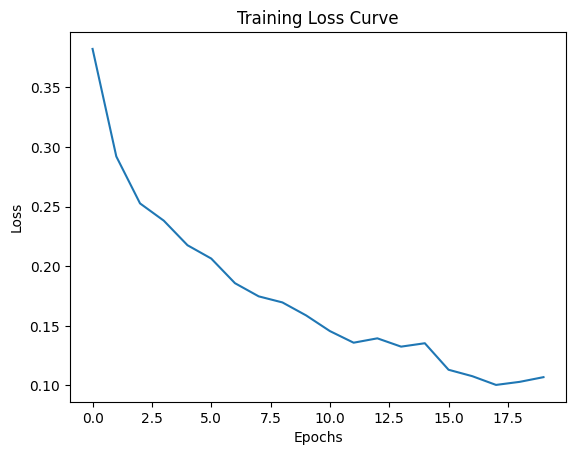

In [12]:
from tqdm import tqdm
from sklearn.metrics import f1_score, recall_score, precision_score
import matplotlib.pyplot as plt

num_classes = 2
cnn_lstm_classifier = CNN_LSTM(embedding_matrix, num_classes=num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_lstm_classifier.parameters(), lr=0.001)

num_epochs = 20

f1_scores = []
recall_scores = []
precision_scores = []
all_losses = []


for epoch in range(num_epochs):
    total_loss = 0
    for batch_X, batch_y in tqdm(train_dataloader):

        outputs = cnn_lstm_classifier(batch_X)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    with torch.no_grad():
        test_outputs = cnn_lstm_classifier(X_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor)
        predicted_labels = torch.argmax(test_outputs, dim=1)

        f1 = f1_score(y_test_tensor.cpu(), predicted_labels.cpu())
        recall = recall_score(y_test_tensor.cpu(), predicted_labels.cpu())
        precision = precision_score(y_test_tensor.cpu(), predicted_labels.cpu())

        f1_scores.append(f1)
        recall_scores.append(recall)
        precision_scores.append(precision)
        all_losses.append(total_loss / len(train_dataloader))

    print(f'Epoch {epoch + 1}/{num_epochs}, Average Loss: {total_loss / len(train_dataloader)}')
    print(f'F1 Score: {f1:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}')

plt.plot(all_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()


100%|██████████| 114/114 [00:33<00:00,  3.37it/s]


Epoch 1/10, Average Loss: 0.3578581236172141
F1 Score: 0.8794, Recall: 0.8472, Precision: 0.9142
Epoch 1/10, Average Loss: 0.3578581236172141


100%|██████████| 114/114 [00:38<00:00,  2.99it/s]


Epoch 2/10, Average Loss: 0.23684975537553168
F1 Score: 0.8842, Recall: 0.8248, Precision: 0.9527
Epoch 2/10, Average Loss: 0.23684975537553168


100%|██████████| 114/114 [00:36<00:00,  3.12it/s]


Epoch 3/10, Average Loss: 0.20529897151547566
F1 Score: 0.8851, Recall: 0.8994, Precision: 0.8712
Epoch 3/10, Average Loss: 0.20529897151547566


100%|██████████| 114/114 [00:37<00:00,  3.07it/s]


Epoch 4/10, Average Loss: 0.18274263344835817
F1 Score: 0.8933, Recall: 0.8894, Precision: 0.8972
Epoch 4/10, Average Loss: 0.18274263344835817


100%|██████████| 114/114 [00:38<00:00,  2.96it/s]


Epoch 5/10, Average Loss: 0.16069366011703223
F1 Score: 0.8949, Recall: 0.9255, Precision: 0.8663
Epoch 5/10, Average Loss: 0.16069366011703223


100%|██████████| 114/114 [00:36<00:00,  3.12it/s]


Epoch 6/10, Average Loss: 0.13885342663055972
F1 Score: 0.8970, Recall: 0.9143, Precision: 0.8804
Epoch 6/10, Average Loss: 0.13885342663055972


100%|██████████| 114/114 [00:36<00:00,  3.16it/s]


Epoch 7/10, Average Loss: 0.11677005589661892
F1 Score: 0.8975, Recall: 0.8807, Precision: 0.9148
Epoch 7/10, Average Loss: 0.11677005589661892


100%|██████████| 114/114 [00:35<00:00,  3.17it/s]


Epoch 8/10, Average Loss: 0.09396526661064279
F1 Score: 0.9109, Recall: 0.8957, Precision: 0.9267
Epoch 8/10, Average Loss: 0.09396526661064279


100%|██████████| 114/114 [00:35<00:00,  3.20it/s]


Epoch 9/10, Average Loss: 0.08802675200920355
F1 Score: 0.9101, Recall: 0.9118, Precision: 0.9084
Epoch 9/10, Average Loss: 0.08802675200920355


100%|██████████| 114/114 [00:36<00:00,  3.12it/s]


Epoch 10/10, Average Loss: 0.06319698989554717
F1 Score: 0.9123, Recall: 0.9106, Precision: 0.9140
Epoch 10/10, Average Loss: 0.06319698989554717


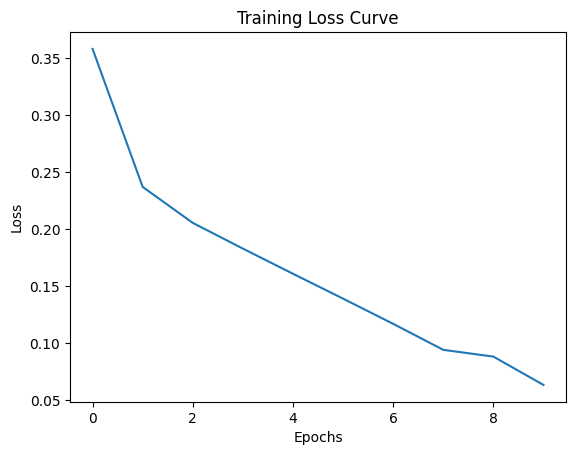

In [13]:
from tqdm import tqdm
num_classes = 2
two_layer_classifier = TwoLayerLSTM(embedding_matrix, num_classes=num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(two_layer_classifier.parameters(), lr=0.001)

num_epochs = 10

f1_scores = []
recall_scores = []
precision_scores = []
all_losses = []


for epoch in range(num_epochs):
    total_loss = 0
    for batch_X, batch_y in tqdm(train_dataloader):

        outputs = two_layer_classifier(batch_X)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    with torch.no_grad():
        test_outputs = two_layer_classifier(X_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor)
        predicted_labels = torch.argmax(test_outputs, dim=1)

        f1 = f1_score(y_test_tensor.cpu(), predicted_labels.cpu())
        recall = recall_score(y_test_tensor.cpu(), predicted_labels.cpu())
        precision = precision_score(y_test_tensor.cpu(), predicted_labels.cpu())

        f1_scores.append(f1)
        recall_scores.append(recall)
        precision_scores.append(precision)
        all_losses.append(total_loss / len(train_dataloader))

    print(f'Epoch {epoch + 1}/{num_epochs}, Average Loss: {total_loss / len(train_dataloader)}')
    print(f'F1 Score: {f1:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}')

    print(f'Epoch {epoch + 1}/{num_epochs}, Average Loss: {total_loss / len(train_dataloader)}')


plt.plot(all_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()


100%|██████████| 114/114 [00:19<00:00,  5.97it/s]


Epoch 1/10, Average Loss: 0.3371637308022432
F1 Score: 0.8840, Recall: 0.8472, Precision: 0.9241
Epoch 1/10, Average Loss: 0.3371637308022432


100%|██████████| 114/114 [00:20<00:00,  5.69it/s]


Epoch 2/10, Average Loss: 0.2318783562565059
F1 Score: 0.8886, Recall: 0.8820, Precision: 0.8953
Epoch 2/10, Average Loss: 0.2318783562565059


100%|██████████| 114/114 [00:18<00:00,  6.06it/s]


Epoch 3/10, Average Loss: 0.2037316710410411
F1 Score: 0.8909, Recall: 0.8522, Precision: 0.9333
Epoch 3/10, Average Loss: 0.2037316710410411


100%|██████████| 114/114 [00:20<00:00,  5.57it/s]


Epoch 4/10, Average Loss: 0.18180933686202033
F1 Score: 0.9003, Recall: 0.8745, Precision: 0.9275
Epoch 4/10, Average Loss: 0.18180933686202033


100%|██████████| 114/114 [00:28<00:00,  4.02it/s]


Epoch 5/10, Average Loss: 0.16273100187250397
F1 Score: 0.9052, Recall: 0.8658, Precision: 0.9483
Epoch 5/10, Average Loss: 0.16273100187250397


100%|██████████| 114/114 [00:24<00:00,  4.70it/s]


Epoch 6/10, Average Loss: 0.14588558232705845
F1 Score: 0.9070, Recall: 0.8845, Precision: 0.9307
Epoch 6/10, Average Loss: 0.14588558232705845


100%|██████████| 114/114 [00:22<00:00,  5.05it/s]


Epoch 7/10, Average Loss: 0.1297441798409349
F1 Score: 0.8973, Recall: 0.8571, Precision: 0.9413
Epoch 7/10, Average Loss: 0.1297441798409349


100%|██████████| 114/114 [00:23<00:00,  4.83it/s]


Epoch 8/10, Average Loss: 0.10744597878829952
F1 Score: 0.9139, Recall: 0.8969, Precision: 0.9316
Epoch 8/10, Average Loss: 0.10744597878829952


100%|██████████| 114/114 [00:19<00:00,  5.82it/s]


Epoch 9/10, Average Loss: 0.09642691942944862
F1 Score: 0.9041, Recall: 0.8609, Precision: 0.9519
Epoch 9/10, Average Loss: 0.09642691942944862


100%|██████████| 114/114 [00:19<00:00,  5.75it/s]


Epoch 10/10, Average Loss: 0.08644698346197083
F1 Score: 0.9130, Recall: 0.8994, Precision: 0.9270
Epoch 10/10, Average Loss: 0.08644698346197083


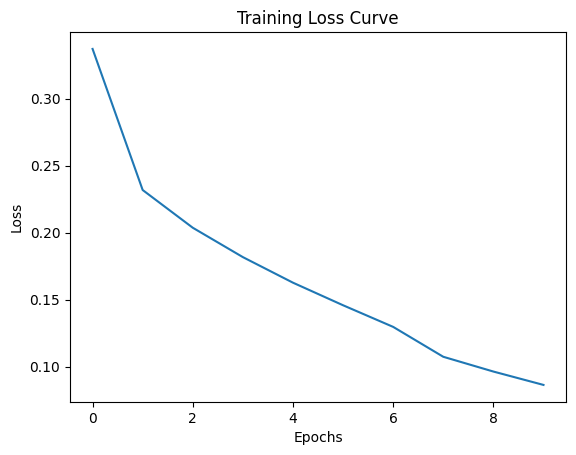

In [14]:
from tqdm import tqdm
num_classes = 2
one_layer_classifier = OneLayerLSTM(embedding_matrix, num_classes=num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(one_layer_classifier.parameters(), lr=0.001)

num_epochs = 10

f1_scores = []
recall_scores = []
precision_scores = []
all_losses = []

for epoch in range(num_epochs):
    total_loss = 0
    for batch_X, batch_y in tqdm(train_dataloader):

        outputs = one_layer_classifier(batch_X)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    with torch.no_grad():
        test_outputs = one_layer_classifier(X_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor)
        predicted_labels = torch.argmax(test_outputs, dim=1)

        f1 = f1_score(y_test_tensor.cpu(), predicted_labels.cpu())
        recall = recall_score(y_test_tensor.cpu(), predicted_labels.cpu())
        precision = precision_score(y_test_tensor.cpu(), predicted_labels.cpu())

        f1_scores.append(f1)
        recall_scores.append(recall)
        precision_scores.append(precision)
        all_losses.append(total_loss / len(train_dataloader))

    print(f'Epoch {epoch + 1}/{num_epochs}, Average Loss: {total_loss / len(train_dataloader)}')
    print(f'F1 Score: {f1:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}')

    print(f'Epoch {epoch + 1}/{num_epochs}, Average Loss: {total_loss / len(train_dataloader)}')


plt.plot(all_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()
